In [ ]:
# Text Classification using Tensorflow Neural Network Model with a word Embedding Layer
# Using Tensorflow Keras Model
#
# Owner: Jacquelyn Carmichael
#
# Uses Libraries: keras, tensorflow
#Runtime: Google Colab
#
# Date: 02/25/2023
#


In [1]:
# import libraries and packages
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.backend import clear_session
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import nlpaug.augmenter.word as naw
import numpy as np
import matplotlib.pyplot as plt
import os

## Download GloVe Word Embeddings

In this notebook, we will work with the GloVe word embeddings from the Stanford NLP Group as their size is more manageable than the Word2Vec word embeddings provided by Google. We will download the 6B (trained on 6 billion words) word embeddings from here (glove.6B.zip, 822 MB).

You can see other pretrained GloVe word embeddings at this URL:
https://nlp.stanford.edu/projects/glove/


In [2]:
GloVe_data = "https://nlp.stanford.edu/data/glove.6B.zip"
GloVe_zip = tf.keras.utils.get_file('glove.6B.zip',GloVe_data, extract=True)
GloVe_file = os.path.join(os.path.dirname(GloVe_zip), 'glove.6B.100d.txt')



        



862182613/862182613 [==============================] - 243s 0us/step


In [3]:
# load the 'glove.6B.100d.txt' file
embeddings_index = {}
with open(GloVe_file) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

        

# Reading in my Dataset



In [5]:
# reading in my data from the github repository to a data frame 

url = "https://raw.githubusercontent.com/JVCarmich0959/CSC228/main/WUG_Mall_improvement.csv"

df = pd.read_csv(url, usecols=[0,1,2], encoding='latin-1')

df = pd.concat([df, pd.read_csv(url, usecols=[0,1,2], encoding='latin-1')])

df.head()


,Source,Label,Sentence
0,Facebook,0,Anything but another damn shoe store.
1,Facebook,1,The mall is a joke. When I worked there 30+ ye...
2,Facebook,1,A Spencerâs
3,Facebook,1,Arcade for kids and teens that serves food whe...
4,Facebook,1,"Dillards, Talbots, Chicoâs."


# Split the Data into Training and Testing Sets

I'm using the train_test_split function  as we did in Lesson 5 from sklearn to split the data into training and testing sets. This is important because we want to train our model on the training set and then test it on the testing set. This will give us a better idea of how well our model will perform on new data.

In [6]:
sentence = df['Sentence'].values
label = df['Label'].values

# split the data into training and testing sets 
sentence_train, sentence_test, label_train, label_test = train_test_split(sentence, label, test_size=0.2, random_state=1000)

# Tokenization and Indexing Vocabulary

Now we will tokenize the data extracted from the csv file in our x and y 
variables. As mentioned in the lecture Keras has some nifty methods for text
preprocessing and sequence preprocessing.

We will start by using the Tokenizer class from Keras to tokenize the data.
This method allows us to map each word to a unique integer value in a dictionary allowing it to be easily processed by the model.

The parameter num_words is responsible for setting the size of the vocabulary so that we don't have a vocabulary that is too large. This will help us avoid the curse of dimensionality.

**Note that the index 0 is reserved for padding.**

Now lets look at the code:

In [7]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentence_train)

x_train = tokenizer.texts_to_sequences(sentence_train)
x_test = tokenizer.texts_to_sequences(sentence_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index



In [8]:

print(sentence_train[2]) # print the first sentence in the training set
print(x_train[2]) # print the first sentence in the training set after it has been tokenized



I love trying on clothes at the mall.
[4, 24, 98, 99, 277, 8, 1, 2]


# Unknown words (words not in the vocabulary) 

are denoted in Keras with word_index + 1 since they can also be mapped to an integer value.

We can see the index of each word by looking at the word_index attribute of the tokenizer object.



In [9]:
for word in [ 'the', 'mall', 'is', 'fun']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))
    

the: 1
mall: 2
is: 6
fun: 43


**Note: The difference between this technique and the X_train that was used with scikit-learn CountVectorizer.**

**CountVectorizer**: The X_train variable is a **sparse matrix** that contains the frequency of each word in the vocabulary. This is a matrix of size (number of documents, size of vocabulary). 

**Tokenizer**: The X_train variable is a **list of lists**. Each list contains the index of each word in the document. This is a list of size (number of documents,). **The size of the vocabulary is the number of unique words in the corpus.** 

## Padding each Vector

One problem with the Tokenizer method is that each document has a different length. This means that we can't feed the data into the model as is. We need to pad each vector so that they are all the same length. This is done by using the pad_sequences method from Keras.

Additionally we can choose to truncate the vectors if they are longer than the max length. This is done by setting the parameter truncating to 'post' or 'pre'.

In [10]:
maxlen = 100 # max number of words in a sentence to use

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

print(x_train[0, :]) # print the first sentence in the training set after it has been tokenized and padded

[  1   2  61  36  11 276   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]


# Build Embedding Matrix

Now we will build the embedding matrix. This is a matrix that contains the word embeddings for each word in the vocabulary. This matrix will be used to initialize the weights of the embedding layer in the model.

The embedding matrix is a matrix of size (size of vocabulary, embedding dimension).



In [11]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

In [12]:
# Extract the Embedding Matrix that maps  exh of our 5000 vocabulary words
# words to their 100 dimensional GloVe embedding
embedding_dim = 100
embedding_matrix = create_embedding_matrix(
    GloVe_file,
    tokenizer.word_index, embedding_dim)

In [13]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9313186813186813

In [14]:


embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=maxlen,
                            weights=[embedding_matrix],
                            trainable=False))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          72800     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 73,821
Trainable params: 1,021
Non-trainable params: 72,800
_________________________________________________________________


# Configure the Model

We will use the Adam optimizer and the binary crossentropy loss function. We will also use the accuracy metric to evaluate the model.



In [16]:
# Configure the model
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])


In [17]:
# In order to retrain from scratch, we need to reinitialize the model
clear_session()

# Train the Model

We will train the model for 50 epochs with a batch size of 10. We will also use the validation_split parameter to split off 20% of the training data to use as a validation set. This will allow us to see how well the model is performing on data it hasn't seen before.

In [18]:
history = model.fit(x_train, label_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(x_test, label_test),
                    batch_size=10)

                    

2023-02-25 14:07:56.507307: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


# Evaluating the Accuracy of our model

We can see that the model is performing well on the training set but not so well on the validation set. This is a sign of overfitting. We can try to reduce overfitting by adding dropout layers to the model.



In [19]:
loss, accuracy = model.evaluate(x_train, label_train, verbose=False)

In [20]:
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, label_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


Training Accuracy: 0.9579
Testing Accuracy:  0.8673


# Dropout Layers

Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

The effect is that the model becomes less sensitive to the specific weights of neurons. This has the effect of making the model more robust, and also reducing the complexity of the model.

We can add dropout layers to our model by using the Dropout class from Keras. We can specify the fraction of the input units to drop. This is done by setting the rate parameter to a value between 0 and 1. For example, we can set rate=0.2 to drop 20% of the input units.

In [23]:
# Adding dropout layers to the model
clear_session()

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          72800     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                        

In [24]:
# Configure the new model with dropout layers
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

# Train the new model
history = model.fit(x_train, label_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(x_test, label_test),
                    batch_size=10)

# Evaluate the new model
loss, accuracy = model.evaluate(x_train, label_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(x_test, label_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))



Training Accuracy: 1.0000
Testing Accuracy:  0.8761


:( Still overfitting lets reconfigure the model with fewer nodes in the dense layer, regularization, early stopping, and more dropout layers.

In [25]:
# reset the model
clear_session()

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          72800     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                        

In [27]:


model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, label_train,
                    epochs=50,
                    batch_size=10,
                    validation_split=0.2,
                    callbacks=[early_stopping])

train_acc = model.evaluate(x_train, label_train, verbose=0)[1]
test_acc = model.evaluate(x_test, label_test, verbose=0)[1]

# print the training accuracy as percent
print('Training accuracy: %.2f%%' % (train_acc*100))

# print the testing accuracy as percent
print('Testing accuracy: %.2f%%' % (test_acc*100))



Epoch 1/50
36/36 [==============================] - 1s 5ms/step - loss: 0.6963 - accuracy: 0.5583 - val_loss: 0.6914 - val_accuracy: 0.5495
Epoch 2/50
36/36 [==============================] - 0s 2ms/step - loss: 0.6721 - accuracy: 0.5861 - val_loss: 0.6770 - val_accuracy: 0.5495
Epoch 3/50
36/36 [==============================] - 0s 2ms/step - loss: 0.6553 - accuracy: 0.5861 - val_loss: 0.6591 - val_accuracy: 0.5495
Epoch 4/50
36/36 [==============================] - 0s 2ms/step - loss: 0.6294 - accuracy: 0.6167 - val_loss: 0.6398 - val_accuracy: 0.5604
Epoch 5/50
36/36 [==============================] - 0s 2ms/step - loss: 0.6248 - accuracy: 0.6389 - val_loss: 0.6159 - val_accuracy: 0.5824
Epoch 6/50
36/36 [==============================] - 0s 2ms/step - loss: 0.5826 - accuracy: 0.6778 - val_loss: 0.5804 - val_accuracy: 0.8352
Epoch 7/50
36/36 [==============================] - 0s 2ms/step - loss: 0.5260 - accuracy: 0.7778 - val_loss: 0.5297 - val_accuracy: 0.8791
Epoch 8/50
36/36 [==

It's still overfit however I can see that the model is performing better on the validation set than the training set. This is a sign that the model is generalizing better. We can also see that the model is still overfitting. We can try to reduce overfitting by adding more dropout layers to the model.


# Visualize the models performance


In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

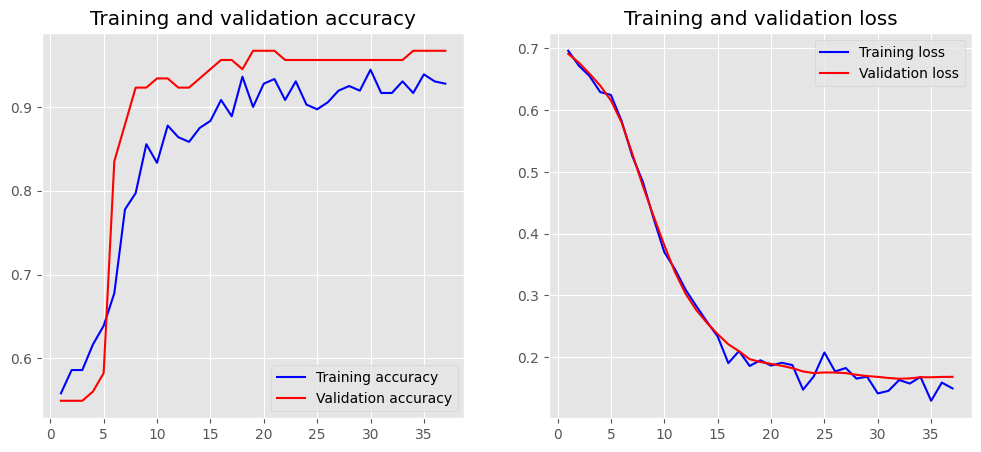

In [30]:
plot_history(history)

# Overfitting: 
The model has learned to fit the training data too closely, including noise or outliers, and is not able to generalize well to new data. This can cause the training loss to decrease while the validation loss increases. This is a sign of overfitting.

# Underfitting: 

The model could be too simple to capture the complex patterns in data, or it could be undertrained. This can cause the training loss to increase while the validation loss decreases. This is a sign of underfitting. (This is not the case here)

# Learning Rate:

The learning rate determines how quickly the model updates its parameters during training. If the learning rate is too small, the model may take a long time to converge. If the learning rate is too large, the model may overshoot the optimal solution. The learning rate is a hyperparameter that you can tune for your problem. (In our case sentiment analysis)

In [31]:
def tryit(sentence):
    seq = tokenizer.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=maxlen)
    pred = model.predict(padded)
    print(sentence)
    print(pred)

tryit('I am never going back')

1/1 [==============================] - 0s 64ms/step
I am never going back
[[0.03765526]]


In [32]:
tryit('I love this place')

tryit('I hate this place')

1/1 [==============================] - 0s 14ms/step
I love this place
[[0.9993467]]
1/1 [==============================] - 0s 13ms/step
I hate this place
[[0.46318966]]


In [33]:
tryit('Not enough parking')

tryit('The food is great')

# The model also correctly predicts this negative sentiment.
# and the model correctly predicts this positive sentiment.

1/1 [==============================] - 0s 15ms/step
Not enough parking
[[0.30539036]]
1/1 [==============================] - 0s 15ms/step
The food is great
[[0.99378455]]


In [34]:
tryit('JC Penny is so dirty.')

tryit('I love JC Penny')

#Anything below a threshold of 0.05 is considered negative so in this case
# our model was correct in it predictions.

# So far this model is performing slightly better than our model in lesson 5

1/1 [==============================] - 0s 13ms/step
JC Penny is so dirty.
[[0.02685778]]
1/1 [==============================] - 0s 14ms/step
I love JC Penny
[[0.99688727]]


In [35]:
tryit('Poor customer service in Belk.')

tryit('I love Belk.')

# The model correctly predicts this negative sentiment.
# And the positive sentiment.


1/1 [==============================] - 0s 13ms/step
Poor customer service in Belk.
[[0.02065702]]
1/1 [==============================] - 0s 14ms/step
I love Belk.
[[0.99845666]]


In [36]:
tryit('Tear the mall down.')

# YAY! The model correctly predicts this negative sentiment.

tryit('The mall needs improvement.')

# The model recoginizes this statement as more positive than negative. 



1/1 [==============================] - 0s 13ms/step
Tear the mall down.
[[0.04044331]]
1/1 [==============================] - 0s 13ms/step
The mall needs improvement.
[[0.7239887]]


# Word Embedding  are Important:

Integrating word embeddings into your neural network can provide the best of both worlds no more feature engineering and the ability to contextualize words in a sentence based on their similarity to other words in a vector, makes it easier for the model to learn the relationship between words and their meaning, and improves the accuracy and performance of the model.
